# A research on identifying the best district in Moscow to buy a flat.
## Baseline: The flat is intended for a family with children
### Criteria:
* Educational organisations
* Health care organizations
* Rest and relaxation

In [510]:
import pandas as pd
import numpy as np
import requests
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library
import pandas_read_xml as pdx

from minisom import MiniSom

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

! pip install folium==0.5.0
import folium # plotting library

# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn import preprocessing, cluster
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


In [3]:
CLIENT_ID = '...' #Key for working with the geocoder

# 1. Data preparation

## 1.1 Preparation of data on objects - __[swimming pools](https://data.mos.ru/opendata/7708308010-basseyny-plavatelnye-otkrytye)__

In [480]:
prep_pools = pd.read_excel('Pools/pools.xlsx')

In [481]:
prep_pools.head()

global_id                                         ObjectName  \
0  282897592  Физкультурно-оздоровительный комплекс с бассей...   
1  407157820                          Фитнес клуб «Ворлд Класс»   
2  407158063  Спортивный комплекс высшего учебного заведения...   
3  407173850  Спортивный комплекс высшего учебного заведения...   
4  407193269                          Фитнес клуб «Ворлд Класс»   

                                   NameWinter  \
0  бассейн плавательный 25-ти метровый крытый   
1                 бассейн плавательный крытый   
2  бассейн плавательный 50-ти метровый крытый   
3  бассейн плавательный 25-ти метровый крытый   
4  бассейн плавательный 25-ти метровый крытый   

                                      PhotoWinter  \
0  Photo:126e8a14-8169-4b05-b424-51b812da6a5e\n\n   
1  Photo:c173e2b2-2d62-4017-9d66-003c6c291985\n\n   
2  Photo:73775081-f3f9-4286-9e78-b296d8914ab2\n\n   
3  Photo:3f8a082f-f943-4758-88e7-d296bceb5393\n\n   
4  Photo:f880b17d-a87f-4a5a-ac4e-41be68d851b0\n\n   

                                   AdmArea            District  \
0  Северо-Восточный административный округ  Алтуфьевский район   
1       Центральный административный округ      район Якиманка   
2       Центральный административный округ     Басманный район   
3  Северо-Восточный административный округ  район Марьина Роща   
4             Южный административный округ       Донской район   

                                      Address            Email  \
0           Инженерная улица, дом 5, корпус 1  s82@mossport.ru   
1            Житная улица, дом 14, строение 1              NaN   
2  Госпитальная набережная, дом 4, строение 2              NaN   
3     Новосущёвская улица, дом 24, строение 1       tu@miit.ru   
4                   Варшавское шоссе, дом 12А              NaN   

                                    WebSite        HelpPhone  ...  \
0                           s82.mossport.ru  (499) 900-90-18  ...   
1   www.worldclass.ru/clubs/zhitnaya/detail  (495) 771-66-00  ...   
2                                  bmstu.ru  (499) 263-22-37  ...   
3                               www.miit.ru  (495) 684-40-25  ...   
4  www.worldclass.ru/clubs/tulskaya/detail/  (495) 633-03-03  ...   

                                 DimensionsWinter  \
0  Square:350\nLength:25\nWidth:14\nDepth:1.8\n\n   
1       Square:60\nLength:15\nWidth:4\nDepth:\n\n   
2    Square:1250\nLength:50\nWidth:25\nDepth:\n\n   
3     Square:350\nLength:25\nWidth:14\nDepth:\n\n   
4      Square:125\nLength:25\nWidth:5\nDepth:\n\n   

                           Lighting     SurfaceTypeWinter Seats    Paid  \
0               смешанное освещение  специальное покрытие     0  платно   
1  освещение газоразрядными лампами  специальное покрытие     0  платно   
2  освещение газоразрядными лампами  специальное покрытие     0  платно   
3     освещение лампами накаливания  специальное покрытие     0  платно   
4               смешанное освещение  специальное покрытие     0  платно   

  PaidComments     DisabilityFriendly               ServicesWinter  \
0          NaN  частично приспособлен  общая физическая подготовка   
1          NaN                    NaN  общая физическая подготовка   
2          NaN  частично приспособлен  общая физическая подготовка   
3          NaN  частично приспособлен  общая физическая подготовка   
4          NaN        не приспособлен  общая физическая подготовка   

                               geodata_center geoarea  
0  01010000003C66FB9505CA4240CCB560568EF04B40     NaN  
1  0101000000479DC225D0CE4240A666ECCDA2DD4B40     NaN  
2  01010000004E336D2150D94240AF0469CAD7E24B40     NaN  
3  0101000000312ECF7B63CD424013FB5FA123E54B40     NaN  
4  0101000000C12C000716CF4240FEF9164C3AD94B40     NaN  

[5 rows x 35 columns]

In [482]:
prep_pools.drop(['global_id', 'PhotoWinter', 'Email', 'WebSite', 'HelpPhone', 'NameWinter', 
                 'HelpPhoneExtension', 'WorkingHoursWinter', 'ClarificationOfWorkingHoursWinter',
                 'HasEquipmentRental', 'EquipmentRentalComments', 'HasTechService', 'DisabilityFriendly',
                 'TechServiceComments', 'Lighting', 'SurfaceTypeWinter', 'geodata_center', 'geoarea',
                 'UsagePeriodWinter', 'DimensionsWinter', 'Seats', 'Paid', 'PaidComments', 'HasDressingRoom',
                 'HasEatery', 'HasToilet', 'HasWifi', 'HasCashMachine', 'HasFirstAidPost', 'HasMusic', 'ServicesWinter'], axis=1, inplace = True)

In [483]:
prep_pools.head()

ObjectName  \
0  Физкультурно-оздоровительный комплекс с бассей...   
1                          Фитнес клуб «Ворлд Класс»   
2  Спортивный комплекс высшего учебного заведения...   
3  Спортивный комплекс высшего учебного заведения...   
4                          Фитнес клуб «Ворлд Класс»   

                                   AdmArea            District  \
0  Северо-Восточный административный округ  Алтуфьевский район   
1       Центральный административный округ      район Якиманка   
2       Центральный административный округ     Басманный район   
3  Северо-Восточный административный округ  район Марьина Роща   
4             Южный административный округ       Донской район   

                                      Address  
0           Инженерная улица, дом 5, корпус 1  
1            Житная улица, дом 14, строение 1  
2  Госпитальная набережная, дом 4, строение 2  
3     Новосущёвская улица, дом 24, строение 1  
4                   Варшавское шоссе, дом 12А

## Count missing values in each column

In [484]:
missing_data = prep_pools.isnull()

In [485]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")   

ObjectName
False    472
Name: ObjectName, dtype: int64

AdmArea
False    472
Name: AdmArea, dtype: int64

District
False    472
Name: District, dtype: int64

Address
False    472
Name: Address, dtype: int64



In [592]:
prep_pools['Category'] = 'Pools'

In [487]:
prep_pools['Longitude'] = ''

In [488]:
prep_pools['Latitude'] = ''

## Getting the geographical coordinates for each object

In [489]:
for index, row in prep_pools.iterrows():
    try:
        address = 'Москва,' + row['Address']
        url = 'https://geocode-maps.yandex.ru/1.x/?format=json&apikey={}&geocode={}'.format(CLIENT_ID, address)
        results = requests.get(url).json()
        venue = results['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
        res = venue.split(sep=" ")
        prep_pools['Latitude'][index] = res[1]
        prep_pools['Longitude'][index] = res[0]  
    except:
        prep_pools['Latitude'][index] = 'Nan'
        prep_pools['Longitude'][index] = 'Nan'  

In [594]:
prep_pools.head(10)

ObjectName  \
0  Физкультурно-оздоровительный комплекс с бассей...   
1                          Фитнес клуб «Ворлд Класс»   
2  Спортивный комплекс высшего учебного заведения...   
3  Спортивный комплекс высшего учебного заведения...   
4                          Фитнес клуб «Ворлд Класс»   
5                             Фитнес-клуб «Пирамида»   
6  Физкультурно-оздоровительный комплекс с бассей...   
7                       Спортивный комплекс «Тушино»   
8                    Спортивный комплекс «Аквамарин»   
9                       Спортивный комплекс «Косино»   

                                   AdmArea                District  \
0  Северо-Восточный административный округ      Алтуфьевский район   
1       Центральный административный округ          район Якиманка   
2       Центральный административный округ         Басманный район   
3  Северо-Восточный административный округ      район Марьина Роща   
4             Южный административный округ           Донской район   
5      Юго-Западный административный округ     Академический район   
6  Северо-Восточный административный округ         район Лианозово   
7   Северо-Западный административный округ   район Северное Тушино   
8   Северо-Западный административный округ            район Митино   
9         Восточный административный округ  район Косино-Ухтомский   

                                      Address Category  Longitude   Latitude  
0           Инженерная улица, дом 5, корпус 1    Pools  37.578298  55.879303  
1            Житная улица, дом 14, строение 1    Pools  37.615632  55.730978  
2  Госпитальная набережная, дом 4, строение 2    Pools  37.696642  55.771753  
3     Новосущёвская улица, дом 24, строение 1    Pools  37.604610  55.790140  
4                   Варшавское шоссе, дом 12А    Pools  37.617860  55.697138  
5              улица Дмитрия Ульянова, дом 31    Pools  37.585440  55.684726  
6        Абрамцевская улица, дом 15, корпус 1    Pools  37.571525  55.906749  
7         улица Вилиса Лациса, домовладение 8    Pools  37.427094  55.865384  
8              улица Рословка, домовладение 5    Pools  37.366583  55.831433  
9            улица Николая Старостина, дом 8А    Pools  37.853093  55.729731

In [491]:
prep_pools.at[35, 'Longitude'] = 37.617959
prep_pools.at[35, 'Latitude'] = 55.898765

prep_pools.at[61, 'Longitude'] = 37.700828
prep_pools.at[61, 'Latitude'] = 55.793288

prep_pools.at[220, 'Longitude'] = 37.429986
prep_pools.at[220, 'Latitude'] = 55.658764

prep_pools.at[317, 'Longitude'] = 37.480849
prep_pools.at[317, 'Latitude'] = 55.621648

prep_pools.at[318, 'Longitude'] = 37.480849
prep_pools.at[318, 'Latitude'] = 55.621648

In [492]:
prep_pools["Longitude"] = pd.to_numeric(prep_pools["Longitude"])

In [493]:
prep_pools["Latitude"] = pd.to_numeric(prep_pools["Latitude"])

In [495]:
address = 'Moscow, RU'

geolocator = Nominatim(user_agent="moscow_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Moscow using latitude and longitude values
map_moscow = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name in zip(prep_pools['Latitude'], prep_pools['Longitude'], prep_pools['ObjectName']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_moscow)  
    
map_moscow

## 1.2 Preparation of data on objects - __[hospitals for adults](https://data.mos.ru/opendata/7707089084-bolnitsy-vzroslye)__

In [21]:
prep_xml_adulthospitals = pdx.read_xml('AdultHospitals/adulthospital.xml', ['catalog'], encoding='windows-1251')

In [24]:
prep_xml_adulthospitals = pdx.flatten(prep_xml_adulthospitals)

In [25]:
prep_xml_adulthospitals.head()

array|ChiefPosition array|ReopenDate array|ClarificationWorkingHours  \
0         главный врач             None                            None   
1  заведующий филиалом             None                            None   
2         главный врач             None                            None   
3  заведующий филиалом             None                            None   
4         главный врач             None                            None   

      array|Category                      array|Email array|PaidServiceInfo  \
0  Больница взрослая  {'Email': 'gkb24@zdrav.mos.ru'}           оказываются   
1  Больница взрослая   {'Email': 'gb17@zdrav.mos.ru'}           отсутствуют   
2  Больница взрослая  {'Email': 'gkb31@zdrav.mos.ru'}           оказываются   
3  Больница взрослая   {'Email': 'gkbb@zdrav.mos.ru'}           оказываются   
4  Больница взрослая    {'Email': 'vgb@zdrav.mos.ru'}           оказываются   

                                     array|ShortName array|CloseFlag  \
0                                  ГБУЗ ГКБ № 24 ДЗМ       действует   
1              ГБУЗ ГКБ № 17 ДЗМ Филиал «Внуковский»       действует   
2                                  ГБУЗ ГКБ № 31 ДЗМ       действует   
3  ГБУЗ ГКБ им. С. П. Боткина филиал № 1 ДЗМ офта...       действует   
4                      ГБУЗ Вороновская больница ДЗМ       действует   

  array|CloseDate                    array|Specialization  ...  \
0            None  многопрофильное медицинское учреждение  ...   
1            None  многопрофильное медицинское учреждение  ...   
2            None  многопрофильное медицинское учреждение  ...   
3            None                           офтальмология  ...   
4            None  многопрофильное медицинское учреждение  ...   

                                  array|WorkingHours  \
0  [{'DayWeek': 'понедельник', 'WorkHours': 'круг...   
1  [{'DayWeek': 'понедельник', 'WorkHours': '08:0...   
2  [{'DayWeek': 'понедельник', 'WorkHours': 'круг...   
3  [{'DayWeek': 'понедельник', 'WorkHours': '08:0...   
4  [{'DayWeek': 'понедельник', 'WorkHours': 'круг...   

                                       array|OrgInfo  \
0  {'OGRN': '1037739726771', 'ChiefPosition': 'гл...   
1  {'OGRN': '1027739805114', 'ChiefPosition': 'гл...   
2  {'OGRN': '1037700216069', 'ChiefPosition': 'гл...   
3  {'OGRN': '1037739085900', 'ChiefPosition': 'гл...   
4  {'OGRN': '1035011457612', 'ChiefPosition': 'гл...   

                                      array|FullName array|ChiefGender  \
0  Государственное бюджетное учреждение здравоохр...           мужской   
1  Государственное бюджетное учреждение здравоохр...           женский   
2  Государственное бюджетное учреждение здравоохр...           женский   
3  Государственное бюджетное учреждение здравоохр...           женский   
4  Государственное бюджетное учреждение здравоохр...           мужской   

                    array|Fax array|Extrainfo  \
0  {'Fax': '(495) 613-04-34'}            None   
1  {'Fax': '(495) 736-62-34'}            None   
2  {'Fax': '(499) 432-08-15'}            None   
3  {'Fax': '(495) 699-01-31'}            None   
4  {'Fax': '(495) 850-71-75'}            None   

                   array|ChiefName  \
0    Родоман Григорий Владимирович   
1     Словеснова Ираида Викторовна   
2      Ефремова Наталья Михайловна   
3  Аржиматова Гульжияна Шевкетовна   
4      Гурин Александр Анатольевич   

                                 array|ObjectAddress  \
0  [{'Availability': {'available_o': 'частично', ...   
1  {'Availability': {'available_o': 'частично', '...   
2  [{'Availability': {'available_o': 'частично', ...   
3  [{'Availability': {'available_o': 'полностью',...   
4  {'Availability': {'available_o': 'частично', '...   

                                array|geodata_center array|DrugStore  
0                                                NaN             NaN  
1  {'type': 'geometry', 'value': '01010000001FA88...             NaN  
2  {'type': 'geometry', 'value': '0101000000590D9...  

In [26]:
prep_xml_adulthospitals = prep_xml_adulthospitals.reset_index()

In [27]:
prep_xml_adulthospitals.index

RangeIndex(start=0, stop=44, step=1)

In [28]:
data = []
for number in range(44):
    try:
        data.append([prep_xml_adulthospitals['array|ShortName'][number], 'None', 'None', prep_xml_adulthospitals['array|ObjectAddress'][number][0]['Address'], 'AdultHospital'])
    except KeyError:
        data.append([prep_xml_adulthospitals['array|ShortName'][number], 'None', 'None', prep_xml_adulthospitals['array|ObjectAddress'][number]['Address'], 'AdultHospital'])
prep_adulthospitals = pd.DataFrame(data, columns=['ObjectName', 'AdmArea', 'District', 'Address', 'Category'])

In [29]:
prep_adulthospitals.head()

ObjectName AdmArea District  \
0                                  ГБУЗ ГКБ № 24 ДЗМ    None     None   
1              ГБУЗ ГКБ № 17 ДЗМ Филиал «Внуковский»    None     None   
2                                  ГБУЗ ГКБ № 31 ДЗМ    None     None   
3  ГБУЗ ГКБ им. С. П. Боткина филиал № 1 ДЗМ офта...    None     None   
4                      ГБУЗ Вороновская больница ДЗМ    None     None   

                                             Address       Category  
0               город Москва, Писцовая улица, дом 10  AdultHospital  
1  город Москва, поселение Внуковское, посёлок Вн...  AdultHospital  
2  город Москва, улица Лобачевского, дом 42, стро...  AdultHospital  
3  город Москва, Мамоновский переулок, дом 7, стр...  AdultHospital  
4  город Москва, поселение Вороновское, посёлок Л...  AdultHospital

In [30]:
prep_adulthospitals['Longitude'] = ''
prep_adulthospitals['Latitude'] = ''

In [31]:
for index, row in prep_adulthospitals.iterrows():
    try:
        address = row['Address']
        url = 'https://geocode-maps.yandex.ru/1.x/?format=json&apikey={}&geocode={}'.format(CLIENT_ID, address)
        results = requests.get(url).json()
        venue = results['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
        res = venue.split(sep=" ")
        prep_adulthospitals['Latitude'][index] = res[1]
        prep_adulthospitals['Longitude'][index] = res[0]  
    except:
        prep_adulthospitals['Latitude'][index] = 'Nan'
        prep_adulthospitals['Longitude'][index] = 'Nan'

In [32]:
prep_adulthospitals.head()

ObjectName AdmArea District  \
0                                  ГБУЗ ГКБ № 24 ДЗМ    None     None   
1              ГБУЗ ГКБ № 17 ДЗМ Филиал «Внуковский»    None     None   
2                                  ГБУЗ ГКБ № 31 ДЗМ    None     None   
3  ГБУЗ ГКБ им. С. П. Боткина филиал № 1 ДЗМ офта...    None     None   
4                      ГБУЗ Вороновская больница ДЗМ    None     None   

                                             Address       Category  \
0               город Москва, Писцовая улица, дом 10  AdultHospital   
1  город Москва, поселение Внуковское, посёлок Вн...  AdultHospital   
2  город Москва, улица Лобачевского, дом 42, стро...  AdultHospital   
3  город Москва, Мамоновский переулок, дом 7, стр...  AdultHospital   
4  город Москва, поселение Вороновское, посёлок Л...  AdultHospital   

   Longitude   Latitude  
0  37.578945  55.798318  
1  37.270948  55.636397  
2  37.501034  55.669691  
3  37.598645  55.767043  
4  37.185357  55.313629

In [33]:
prep_adulthospitals["Longitude"] = pd.to_numeric(prep_adulthospitals["Longitude"])

In [34]:
prep_adulthospitals["Latitude"] = pd.to_numeric(prep_adulthospitals["Latitude"])

In [35]:
address = 'Moscow, RU'

geolocator = Nominatim(user_agent="moscow_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Moscow using latitude and longitude values
map_moscow = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name in zip(prep_adulthospitals['Latitude'], prep_adulthospitals['Longitude'], prep_adulthospitals['ObjectName']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_moscow)  
    
map_moscow

## 1.3 Preparation of data on objects - __[Dental clinic for adults](https://data.mos.ru/opendata/7707089084-healthcare-facilities-dental-clinic-for-adults)__

In [36]:
prep_xml_adultdentalcare = pdx.read_xml('AdultDentalСare/adultdentalcare.xml', ['catalog'], encoding='windows-1251')

In [41]:
prep_xml_adultdentalcare = pdx.flatten(prep_xml_adultdentalcare)

In [42]:
prep_xml_adultdentalcare.head()

array|ChiefPosition array|ReopenDate  \
0                            главный врач             None   
1                            главный врач             None   
2                            главный врач             None   
3                            главный врач             None   
4  исполняющий обязанности главного врача             None   

  array|ClarificationWorkingHours array|AmbulanceStation  \
0                            None                    нет   
1                            None                    нет   
2                            None                    нет   
3                            None                    нет   
4                            None                    нет   

                           array|Category  \
0  Стоматологическая поликлиника взрослая   
1  Стоматологическая поликлиника взрослая   
2  Стоматологическая поликлиника взрослая   
3  Стоматологическая поликлиника взрослая   
4  Стоматологическая поликлиника взрослая   

                            array|Email array|PaidServiceInfo  \
0         {'Email': 'sp7@zdrav.mos.ru'}           оказываются   
1        {'Email': 'sp24@zdrav.mos.ru'}           отсутствуют   
2  {'Email': 'info@wgb.mosgorzdrav.ru'}           оказываются   
3        {'Email': 'SP19@zdrav.mos.ru'}           оказываются   
4         {'Email': 'sp3@zdrav.mos.ru'}           оказываются   

                               array|ShortName array|CloseFlag  \
0                              ГАУЗ СП № 7 ДЗМ       действует   
1   ГАУЗ СП № 24 ДЗМ. Ортопедическое отделение       действует   
2  ГБУЗ ЩГБ ДЗМ. Стоматологическая поликлиника       действует   
3                             ГАУЗ СП № 19 ДЗМ       действует   
4                              ГАУЗ СП № 3 ДЗМ       действует   

  array|CloseDate  ...                                      array|OrgInfo  \
0            None  ...  {'OGRN': '1037736032069', 'ChiefPosition': 'гл...   
1            None  ...  {'OGRN': '1037726012686', 'ChiefPosition': 'гл...   
2            None  ...  {'OGRN': '1035011454400', 'ChiefPosition': 'гл...   
3            None  ...  {'OGRN': '1027700299274', 'ChiefPosition': 'гл...   
4            None  ...  {'OGRN': '1037700123042', 'ChiefPosition': 'ис...   

  array|DrugStore       array|DoctorsSpecialtiesListForSelfRecording  \
0             нет  [Врач-стоматолог-терапевт, Врач-стоматолог-хир...   
1             нет  [Врач-стоматолог-терапевт, Врач-стоматолог-хир...   
2             нет  [Врач-стоматолог-терапевт, Врач-стоматолог-хир...   
3             нет  [Врач-стоматолог-терапевт, Врач-стоматолог-хир...   
4             нет  [Врач-стоматолог-терапевт, Врач-стоматолог-хир...   

                                      array|FullName  array|ChiefGender  \
0  Государственное автономное учреждение здравоох...            мужской   
1  Государственное автономное учреждение здравоох...            мужской   
2  Государственное бюджетное учреждение здравоохр...            женский   
3  Государственное автономное учреждение здравоох...            женский   
4  Государственное автономное учреждение здравоох...            женский   

                    array|Fax  \
0  {'Fax': '(499) 137-63-29'}   
1  {'Fax': '(499) 610-73-52'}   
2  {'Fax': '(495) 867-02-79'}   
3  {'Fax': '(499) 246-16-72'}   
4  {'Fax': '(499) 236-52-93'}   

                                     array|Extrainfo  \
0  Проезд: м. «Ленинский проспект», две остановки...   
1                                               None   
2                                               None   
3  Проезд: м. «Фрунзенская».\nОт станции метро &q...   
4  Проезд:ст.м.Серпуховская,с выходом к экономиче...   

                 array|ChiefName  \
0         Вартанов Олег Игоревич   
1     Гринев Андрей Валентинович   
2       Лисицина Елена Вадимовна   
3  Остроухова Алла Александровна   
4    Могучева Людмила Викторовна   

                                 array|ObjectAddress array|geodata_center  
0  {'Availability': {'available_o': 'частично', '... 

In [43]:
prep_xml_adultdentalcare.index

RangeIndex(start=0, stop=67, step=1)

In [44]:
data = []
for number in range(67):
    try:
        data.append([prep_xml_adultdentalcare['array|ShortName'][number], 'None', 'None', prep_xml_adultdentalcare['array|ObjectAddress'][number][0]['Address'], 'AdultDentalClinic'])
    except KeyError:
        data.append([prep_xml_adultdentalcare['array|ShortName'][number], 'None', 'None', prep_xml_adultdentalcare['array|ObjectAddress'][number]['Address'], 'AdultDentalClinic'])
prep_adultdentalcare = pd.DataFrame(data, columns=['ObjectName', 'AdmArea', 'District', 'Address', 'Category'])

In [45]:
prep_adultdentalcare.head()

ObjectName AdmArea District  \
0                              ГАУЗ СП № 7 ДЗМ    None     None   
1   ГАУЗ СП № 24 ДЗМ. Ортопедическое отделение    None     None   
2  ГБУЗ ЩГБ ДЗМ. Стоматологическая поликлиника    None     None   
3                             ГАУЗ СП № 19 ДЗМ    None     None   
4                              ГАУЗ СП № 3 ДЗМ    None     None   

                                             Address           Category  
0           город Москва, Ленинский проспект, дом 40  AdultDentalClinic  
1  город Москва, Симферопольский бульвар, дом 15,...  AdultDentalClinic  
2  город Москва, город Щербинка, Театральная улиц...  AdultDentalClinic  
3  город Москва, Олсуфьевский переулок, дом 1, ст...  AdultDentalClinic  
4                 город Москва, улица Щипок, дом 6/8  AdultDentalClinic

In [46]:
prep_adultdentalcare['Longitude'] = ''
prep_adultdentalcare['Latitude'] = ''

In [47]:
for index, row in prep_adultdentalcare.iterrows():
    try:
        address = row['Address']
        url = 'https://geocode-maps.yandex.ru/1.x/?format=json&apikey={}&geocode={}'.format(CLIENT_ID, address)
        results = requests.get(url).json()
        venue = results['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
        res = venue.split(sep=" ")
        prep_adultdentalcare['Latitude'][index] = res[1]
        prep_adultdentalcare['Longitude'][index] = res[0]  
    except:
        prep_adultdentalcare['Latitude'][index] = 'Nan'
        prep_adultdentalcare['Longitude'][index] = 'Nan'

In [48]:
prep_adultdentalcare["Longitude"] = pd.to_numeric(prep_adultdentalcare["Longitude"])

In [49]:
prep_adultdentalcare["Latitude"] = pd.to_numeric(prep_adultdentalcare["Latitude"])

In [50]:
address = 'Moscow, RU'

geolocator = Nominatim(user_agent="moscow_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Moscow using latitude and longitude values
map_moscow = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name in zip(prep_adultdentalcare['Latitude'], prep_adultdentalcare['Longitude'], prep_adultdentalcare['ObjectName']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_moscow)  
    
map_moscow

## 1.4 Preparation of data on objects - __[Dental clinic for children](https://data.mos.ru/opendata/7707089084-healthcare-institutions-dental-clinic-for-children)__

In [51]:
prep_xml_childrendentalcare = pdx.read_xml('ChildDentalCare/childdentalcare.xml', ['catalog'], encoding='windows-1251')

In [54]:
prep_xml_childrendentalcare = pdx.flatten(prep_xml_childrendentalcare)

In [55]:
prep_xml_childrendentalcare.head()

array|ChiefPosition array|ReopenDate  \
0                            главный врач             None   
1                            главный врач             None   
2                            главный врач             None   
3  исполняющий обязанности главного врача             None   
4                            главный врач             None   

                     array|ClarificationWorkingHours array|AmbulanceStation  \
0                                               None                    нет   
1                                               None                    нет   
2  Вне часы работы поликлиники, в выходные и праз...                    нет   
3                                               None                    нет   
4                                               None                     да   

                          array|Category                      array|Email  \
0  Стоматологическая поликлиника детская  {'Email': 'dsp46@zdrav.mos.ru'}   
1  Стоматологическая поликлиника детская   {'Email': 'dsp6@zdrav.mos.ru'}   
2  Стоматологическая поликлиника детская  {'Email': 'dsp54@zdrav.mos.ru'}   
3  Стоматологическая поликлиника детская   {'Email': 'sp66@zdrav.mos.ru'}   
4  Стоматологическая поликлиника детская  {'Email': 'dsp26@zdrav.mos.ru'}   

  array|PaidServiceInfo                          array|ShortName  \
0           оказываются                        ГБУЗ ДСП № 46 ДЗМ   
1           оказываются                         ГБУЗ ДСП № 6 ДЗМ   
2           оказываются                        ГБУЗ ДСП № 54 ДЗМ   
3           оказываются      ГАУЗ СП № 66 ДЗМ. Детское отделение   
4           отсутствуют  ГБУЗ ДСП № 26 ДЗМ. Отделение ортодонтии   

  array|CloseFlag array|CloseDate  ...  \
0       действует            None  ...   
1       действует            None  ...   
2       действует            None  ...   
3       действует            None  ...   
4       действует            None  ...   

                                       array|OrgInfo array|DrugStore  \
0  {'OGRN': '1037739702880', 'ChiefPosition': 'гл...             нет   
1  {'OGRN': '1037723020279', 'ChiefPosition': 'гл...             нет   
2  {'OGRN': '1037700236254', 'ChiefPosition': 'гл...             нет   
3  {'OGRN': '1037739392250', 'ChiefPosition': 'ис...             нет   
4  {'OGRN': '1037734011457', 'ChiefPosition': 'гл...             нет   

        array|DoctorsSpecialtiesListForSelfRecording  \
0  [Врач-стоматолог детский, Врач-стоматолог-хирург]   
1  [Врач-стоматолог детский, Врач-стоматолог-хирург]   
2  [Врач-стоматолог детский, Врач-стоматолог-хирург]   
3  [Врач-стоматолог детский, Врач-стоматолог-хирург]   
4  [Врач-стоматолог детский, Врач-стоматолог-хирург]   

                                      array|FullName array|ChiefGender  \
0  Государственное бюджетное учреждение здравоохр...           мужской   
1  Государственное бюджетное учреждение здравоохр...           мужской   
2  Государственное бюджетное учреждение здравоохр...           женский   
3  Государственное автономное учреждение здравоох...           мужской   
4  Государственное бюджетное учреждение здравоохр...           женский   

                    array|Fax  \
0  {'Fax': '(495) 303-31-53'}   
1  {'Fax': '(495) 345-93-14'}   
2  {'Fax': '(499) 131-32-20'}   
3  {'Fax': '(495) 674-31-09'}   
4  {'Fax': '(499) 190-47-38'}   

                                     array|Extrainfo  \
0  Проезд: метро «Новогиреево», автобус 211, 141;...   
1  Проезд: метро «Братиславская», далее автобус и...   
2  Проезд: метро «Проспект Вернадского», далее ав...   
3  Проезд: м.Пролетарская, Волгоградский пр-т, Ма...   
4  по полису ОМС.\nПроезд: м. Щукинская, далее пе...   

                  array|ChiefName  \
0          Чуянов Юрий Васильевич   
1      Даллакян Ваграм Феликсович   
2        Козачук Галина Федоровна   
3  Баштовой Алексей Александрович   
4         Попова Ольга Леонидовна   

                                 array|ObjectAddress array|geodata_center  

In [56]:
prep_xml_childrendentalcare.index

RangeIndex(start=0, stop=40, step=1)

In [57]:
data = []
for number in range(40):
    try:
        data.append([prep_xml_childrendentalcare['array|ShortName'][number], 'None', 'None', prep_xml_childrendentalcare['array|ObjectAddress'][number][0]['Address'], 'ChildrenDentalClinic'])
    except KeyError:
        data.append([prep_xml_childrendentalcare['array|ShortName'][number], 'None', 'None', prep_xml_childrendentalcare['array|ObjectAddress'][number]['Address'], 'ChildrenDentalClinic'])
prep_childrendentalcare = pd.DataFrame(data, columns=['ObjectName', 'AdmArea', 'District', 'Address', 'Category'])

In [58]:
prep_childrendentalcare.head()

ObjectName AdmArea District  \
0                        ГБУЗ ДСП № 46 ДЗМ    None     None   
1                         ГБУЗ ДСП № 6 ДЗМ    None     None   
2                        ГБУЗ ДСП № 54 ДЗМ    None     None   
3      ГАУЗ СП № 66 ДЗМ. Детское отделение    None     None   
4  ГБУЗ ДСП № 26 ДЗМ. Отделение ортодонтии    None     None   

                                             Address              Category  
0         город Москва, Новогиреевская улица, дом 17  ChildrenDentalClinic  
1  город Москва, Марьинский бульвар, дом 10, корп...  ChildrenDentalClinic  
2               город Москва, улица Удальцова, дом 4  ChildrenDentalClinic  
3              город Москва, Сосинский проезд, дом 8  ChildrenDentalClinic  
4  город Москва, улица Маршала Новикова, дом 4, к...  ChildrenDentalClinic

In [59]:
prep_childrendentalcare['Longitude'] = ''
prep_childrendentalcare['Latitude'] = ''

In [60]:
for index, row in prep_childrendentalcare.iterrows():
    try:
        address = row['Address']
        url = 'https://geocode-maps.yandex.ru/1.x/?format=json&apikey={}&geocode={}'.format(CLIENT_ID, address)
        results = requests.get(url).json()
        venue = results['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
        res = venue.split(sep=" ")
        prep_childrendentalcare['Latitude'][index] = res[1]
        prep_childrendentalcare['Longitude'][index] = res[0]
        
    except:
        prep_childrendentalcare['Latitude'][index] = 'Nan'
        prep_childrendentalcare['Longitude'][index] = 'Nan'

In [61]:
prep_childrendentalcare["Longitude"] = pd.to_numeric(prep_childrendentalcare["Longitude"])

In [62]:
prep_childrendentalcare["Latitude"] = pd.to_numeric(prep_childrendentalcare["Latitude"])

In [63]:
address = 'Moscow, RU'

geolocator = Nominatim(user_agent="moscow_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Moscow using latitude and longitude values
map_moscow = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name in zip(prep_adultdentalcare['Latitude'], prep_adultdentalcare['Longitude'], prep_adultdentalcare['ObjectName']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_moscow)  
    
map_moscow

## 1.5 Preparation of data on objects - __[hospitals for children](https://data.mos.ru/opendata/7707089084-healthcare-institutions-specialized-and-childrens-hospitals)__

In [445]:
prep_xml_childrenhospital = pdx.read_xml('ChildrenHospitals/childrenhospital.xml', ['catalog'], encoding='windows-1251')

In [448]:
prep_xml_childrenhospital = pdx.flatten(prep_xml_childrenhospital)

In [449]:
prep_xml_childrenhospital.head()

array|ChiefPosition array|ReopenDate  \
0                            главный врач             None   
1                            главный врач             None   
2                            главный врач             None   
3  исполняющий обязанности главного врача             None   
4                            главный врач             None   

         array|ClarificationWorkingHours  \
0                                   None   
1                                   None   
2                                   None   
3  третья суббота месяца с 8:00 до 20:00   
4                                   None   

                          array|Category  \
0  Больница детская и специализированная   
1  Больница детская и специализированная   
2  Больница детская и специализированная   
3  Больница детская и специализированная   
4  Больница детская и специализированная   

                              array|Email array|PaidServiceInfo  \
0  {'Email': 'info@mdgkb.mosgorzdrav.ru'}           оказываются   
1         {'Email': 'gkb67@zdrav.mos.ru'}           отсутствуют   
2         {'Email': 'gkb70@zdrav.mos.ru'}           оказываются   
3            {'Email': 'bk@zdrav.mos.ru'}           отсутствуют   
4         {'Email': 'dgkb9@zdrav.mos.ru'}           оказываются   

                                     array|ShortName  \
0                          ГБУЗ Морозовская ДГКБ ДЗМ   
1  ГБУЗ ГКБ № 67 им. Л. А. Ворохобова ДЗМ. Детско...   
2    ГБУЗ ГКБ им. Е.О. Мухина ДЗМ. Детское отделение   
3   ГБУЗ Больница «Кузнечики» ДЗМ. Детское отделение   
4            ГБУЗ ДГКБ № 9 им. Г. Н. Сперанского ДЗМ   

                                array|geodata_center array|CloseFlag  \
0  {'type': 'geometry', 'value': '010100000053F31...       действует   
1                                                NaN       действует   
2  {'type': 'geometry', 'value': '0101000000A9148...       действует   
3                                                NaN       действует   
4                                                NaN       действует   

  array|CloseDate  ... array|BeneficialDrugPrescription  \
0            None  ...                             None   
1            None  ...                             None   
2            None  ...                             None   
3            None  ...                             None   
4            None  ...                             None   

                                       array|geoData  \
0  {'coordinates': [{'array': ['37.619745922548',...   
1  {'coordinates': {'array': ['37.466007827114', ...   
2  {'coordinates': {'array': ['37.814071598966', ...   
3  {'coordinates': {'array': ['37.450696233232', ...   
4  {'coordinates': [{'array': ['37.539189284171',...   

                                  array|WorkingHours  \
0  [{'DayWeek': 'понедельник', 'WorkHours': 'круг...   
1  [{'DayWeek': 'понедельник', 'WorkHours': 'круг...   
2  [{'DayWeek': 'понедельник', 'WorkHours': '08:0...   
3  [{'DayWeek': 'понедельник', 'WorkHours': '08:0...   
4  [{'DayWeek': 'понедельник', 'WorkHours': 'круг...   

                                       array|OrgInfo  \
0  {'OGRN': '1027739783620', 'ChiefPosition': 'гл...   
1  {'OGRN': '1037734010467', 'ChiefPosition': 'гл...   
2  {'OGRN': '1037700233790', 'ChiefPosition': 'гл...   
3  {'OGRN': '1035011454741', 'ChiefPosition': 'ис...   
4  {'OGRN': '1027739190050', 'ChiefPosition': 'гл...   

                                      array|FullName array|ChiefGender  \
0  Государственное бюджетное учреждение здравоохр...           мужской   
1  Государственное бюджетное учреждение здравоохр...           мужской   
2  Государственное бюджетное учреждение здравоохр...           мужской   
3  Государственное бюджетное учреждение здравоохр...           женский   
4  Государственное бюджетное учреждение здравоохр...           мужской   

                    array|Fax array|Extrainfo  \
0  {'Fax': '(499) 236-22-13'}            None   
1  {'Fax': '(495) 530-33-53'}        

In [450]:
prep_xml_childrenhospital.index

RangeIndex(start=0, stop=15, step=1)

In [451]:
data = []
for number in range(15):
    try:
        data.append([prep_xml_childrenhospital['array|ShortName'][number], 'None', 'None', prep_xml_childrenhospital['array|ObjectAddress'][number][0]['Address'], 'ChildrenHospital'])
    except KeyError:
        data.append([prep_xml_childrenhospital['array|ShortName'][number], 'None', 'None', prep_xml_childrenhospital['array|ObjectAddress'][number]['Address'], 'ChildrenHospital'])
prep_childrenhospital = pd.DataFrame(data, columns=['ObjectName', 'AdmArea', 'District', 'Address', 'Category'])

In [452]:
prep_childrenhospital.head()

ObjectName AdmArea District  \
0                          ГБУЗ Морозовская ДГКБ ДЗМ    None     None   
1  ГБУЗ ГКБ № 67 им. Л. А. Ворохобова ДЗМ. Детско...    None     None   
2    ГБУЗ ГКБ им. Е.О. Мухина ДЗМ. Детское отделение    None     None   
3   ГБУЗ Больница «Кузнечики» ДЗМ. Детское отделение    None     None   
4            ГБУЗ ДГКБ № 9 им. Г. Н. Сперанского ДЗМ    None     None   

                                             Address          Category  
0  город Москва, 4-й Добрынинский переулок, дом 1...  ChildrenHospital  
1         город Москва, улица Саляма Адиля, дом 2/44  ChildrenHospital  
2  Российская Федерация, город Москва, внутригоро...  ChildrenHospital  
3  город Москва, поселение Щаповское, село Озноби...  ChildrenHospital  
4  город Москва, Шмитовский проезд, дом 29, строе...  ChildrenHospital

In [453]:
prep_childrenhospital['Longitude'] = ''
prep_childrenhospital['Latitude'] = ''

In [457]:
for index, row in prep_childrenhospital.iterrows():
    try:
        address = row['Address']
        url = 'https://geocode-maps.yandex.ru/1.x/?format=json&apikey={}&geocode={}'.format(CLIENT_ID, address)
        results = requests.get(url).json()
        venue = results['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
        res = venue.split(sep=" ")
        prep_childrenhospital['Latitude'][index] = res[1]
        prep_childrenhospital['Longitude'][index] = res[0] 
    except:
        prep_childrenhospital['Latitude'][index] = 'Nan'
        prep_childrenhospital['Longitude'][index] = 'Nan'

In [458]:
prep_childrenhospital["Longitude"] = pd.to_numeric(prep_childrenhospital["Longitude"])

In [459]:
prep_childrenhospital["Latitude"] = pd.to_numeric(prep_childrenhospital["Latitude"])

In [460]:
address = 'Moscow, RU'

geolocator = Nominatim(user_agent="moscow_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Moscow using latitude and longitude values
map_moscow = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name in zip(prep_childrenhospital['Latitude'], prep_childrenhospital['Longitude'], prep_childrenhospital['ObjectName']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_moscow)  
    
map_moscow

## 1.6 Preparation of data on objects - __[School](https://www.kaggle.com/nikitasin/moscow-schools?select=school_data.csv)__

In [589]:
prep_school = pd.read_csv('EducationData/school_data.csv')

In [590]:
prep_school.head()

name  \
0                                       Школа № 1239   
1                   Школа № 1231 имени В.Д. Поленова   
2  Школа № 1277 с углубленным изучением немецкого...   
3                            Пятьдесят седьмая школа   
4                                       Школа № 1535   

                                        adress  lattitude  longitude  
0        Вспольный переулок, дом 6, строение 3  55.760292  37.588808  
1  Спасопесковский переулок, дом 6, строение 7  55.749866  37.589033  
2                         Сущевская ул., д. 32  55.783848  37.602067  
3       Малый Знаменский переулок, 7/10 стр. 5  55.748615  37.604987  
4                            ул. Усачева, д.50  55.725803  37.564931

In [601]:
prep_school['Category'] = 'School'
prep_school['AdmArea'] = ''
prep_school['District'] = ''
prep_school.rename(columns={"name": "ObjectName", "adress": "Address", "lattitude": "Latitude", "longitude": "Longitude"}, inplace = True)
prep_school = prep_school[['ObjectName', 'AdmArea', 'District', 'Address', 'Category', 'Longitude', 'Latitude']]
prep_school.head()

ObjectName AdmArea District  \
0                                       Школа № 1239                    
1                   Школа № 1231 имени В.Д. Поленова                    
2  Школа № 1277 с углубленным изучением немецкого...                    
3                            Пятьдесят седьмая школа                    
4                                       Школа № 1535                    

                                       Address Category  Longitude   Latitude  
0        Вспольный переулок, дом 6, строение 3   School  37.588808  55.760292  
1  Спасопесковский переулок, дом 6, строение 7   School  37.589033  55.749866  
2                         Сущевская ул., д. 32   School  37.602067  55.783848  
3       Малый Знаменский переулок, 7/10 стр. 5   School  37.604987  55.748615  
4                            ул. Усачева, д.50   School  37.564931  55.725803

In [602]:
address = 'Moscow, RU'

geolocator = Nominatim(user_agent="moscow_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Moscow using latitude and longitude values
map_moscow = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name in zip(prep_school['Latitude'], prep_school['Longitude'], prep_school['ObjectName']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_moscow)  
    
map_moscow

## 1.7 Get information about the district through geocoding

In [625]:
objects = pd.concat([prep_pools, prep_adulthospitals, prep_adultdentalcare, prep_childrendentalcare, prep_childrenhospital, prep_school], axis=0)

In [626]:
objects.reset_index(inplace = True)

In [627]:
objects.to_csv(r'objects.csv')

In [628]:
for index, row in objects.iterrows():
    try:
        long = str(objects['Longitude'].iloc[index])
        lat = str(objects['Latitude'].iloc[index])
        address = long + ',' + lat
        print(index, address)
        url = 'https://geocode-maps.yandex.ru/1.x/?format=json&apikey={}&geocode={}'.format(CLIENT_ID, address)
        results = requests.get(url).json()
        objects.at[index, 'AdmArea'] = results['response']['GeoObjectCollection']['featureMember'][2]['GeoObject']['metaDataProperty']['GeocoderMetaData']['Address']['Components'][4]['name']
        objects.at[index, 'District'] = results['response']['GeoObjectCollection']['featureMember'][2]['GeoObject']['metaDataProperty']['GeocoderMetaData']['Address']['Components'][5]['name']
    except:
        print('error')

0 37.578298,55.879303
1 37.615632,55.730978
2 37.696642,55.771753000000004
3 37.60461,55.79014
4 37.61786,55.697138
5 37.585440000000006,55.684726
6 37.571525,55.906749
7 37.427094,55.865384
8 37.366583,55.831433
error
9 37.853093,55.72973100000001
10 37.853093,55.72973100000001
11 37.829799,55.759775
12 37.826017,55.746821
13 37.83359,55.724915
14 37.83359,55.724915
15 37.898008000000004,55.723055
16 37.567464,55.901833999999994
17 37.668597,55.785468
18 37.668597,55.785468
19 37.781524,55.70071
20 37.849571000000005,55.691902
21 37.737893,55.73186
22 37.726071000000005,55.649097999999995
23 37.56017,55.783590000000004
24 37.310375,55.613489
error
25 37.356468,55.832246999999995
26 37.356468,55.832246999999995
27 37.489697,55.882414000000004
28 37.563871,55.86228199999999
29 37.535061999999996,55.887251
30 37.469782,55.878586
31 37.447656,55.791430000000005
32 37.403073,55.646756
33 37.476869,55.67499599999999
34 37.519036,55.60479300000001
35 37.617959,55.898765
36 37.548536999999996

In [629]:
objects.to_csv(r'objects.csv')

## 1.8 Object clustering

#### A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

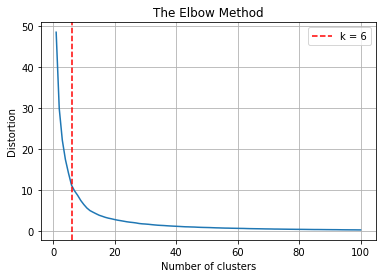

In [645]:
X = objects[["Latitude","Longitude"]]
max_k = 100

# iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)
# best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i in np.diff(distortions,2)]))

# plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

#### k-means clustering

In [646]:
k = 6
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = objects[["Latitude","Longitude"]]

# clustering
objects_X = X.copy()
objects_X["cluster"] = model.fit_predict(X)

# find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     objects_X.drop("cluster", axis=1).values)
objects_X["centroids"] = 0
for i in closest:
    objects_X["centroids"].iloc[i] = 1

# add clustering info to the original dataset
objects[["cluster","centroids"]] = objects_X[["cluster","centroids"]]
objects.sample(5)

/Users/maxim/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


index                                         ObjectName  \
1132    494      Школа № 1359 имени авиаконструктора М.Л. Миля   
426     426                     Фитнес клуб «Вандерфит фитнес»   
363     363  Спортивный комплекс дошкольного образовательно...   
1087    449                                       Школа № 1311   
877     239  Школа самоопределения № 734 имени А.Н. Тубельс...   

                                   AdmArea                   District  \
1132  Юго-Восточный административный округ      район Выхино-Жулебино   
426        Западный административный округ              район Кунцево   
363   Юго-Восточный административный округ      район Выхино-Жулебино   
1087   Юго-Западный административный округ          Обручевский район   
877       Восточный административный округ  район Восточное Измайлово   

                                            Address Category  Longitude  \
1132                Пронская улица, дом 4, корпус 1   School  37.845340   
426             Рублёвское шоссе, дом 101, корпус 3    Pools  37.421497   
363   улица Авиаконструктора Миля, дом 13, корпус 2    Pools  37.858204   
1087                Ленинский проспект, д. 97, к. 1   School  37.523249   
877                      Сиреневый бульвар, дом 58А   School  37.824490   

       Latitude  cluster  centroids  
1132  55.701501        2          0  
426   55.741490        0          0  
363   55.681965        2          0  
1087  55.671270        5          0  
877   55.801293        2          0

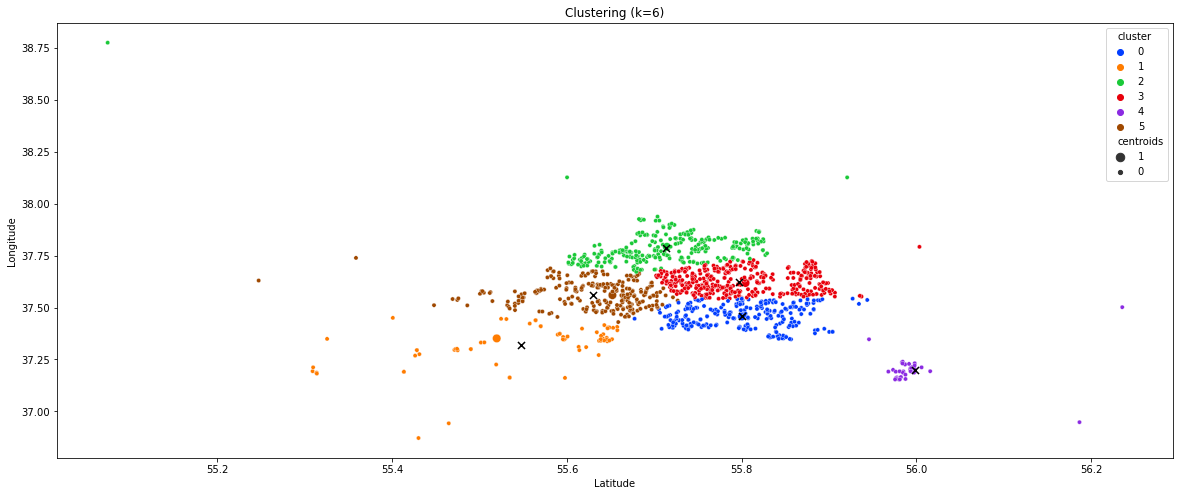

In [647]:
fig, ax = plt.subplots()

fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(20, 8)

sns.scatterplot(x="Latitude", y="Longitude", data=objects, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', marker="x")

#### Affinity Propagation is a graph-based algorithm that assigns each observation to its nearest exemplar. Basically, all the observations “vote” for which other observations they want to be associated with, which results in a partitioning of the whole dataset into a large number of uneven clusters. It’s quite convenient when you can’t specify the number of clusters, and it’s suited for geospatial data as it works well with non-flat geometry.

In [648]:
model_affprop = cluster.AffinityPropagation()

Text(0.5, 1.0, 'Clustering (k=6)')

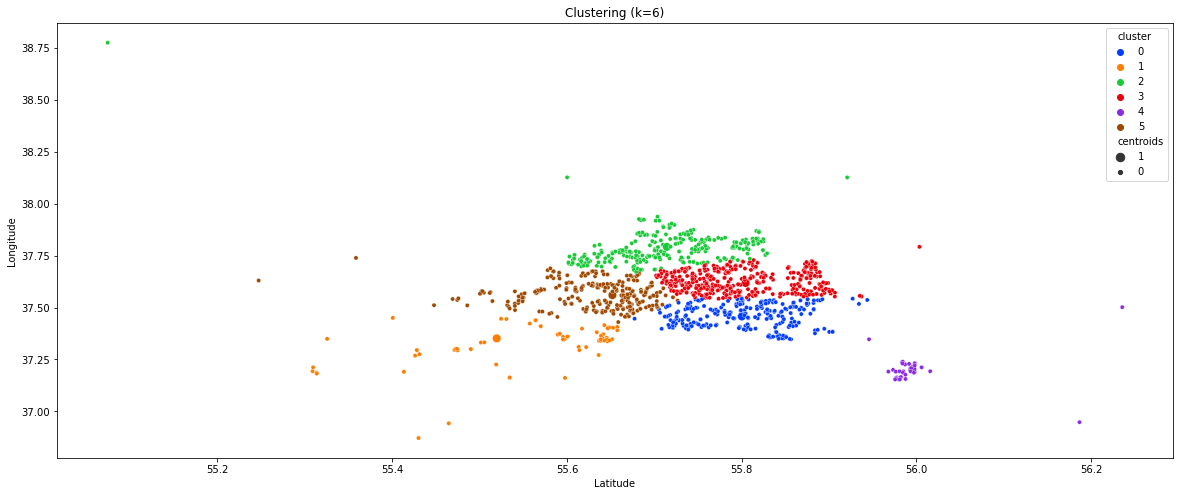

In [649]:
k = objects["cluster"].nunique()

fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(20, 8)

sns.scatterplot(x="Latitude", y="Longitude", data=objects, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief").set_title('Clustering (k='+str(k)+')')

#### Self Organizing Maps (SOMs) are quite different as they use deep learning. In fact, A SOM is a type of artificial neural network that is trained using unsupervised learning to produce a low-dimensional representation of the input space, called a “map” (also referred to as Kohonen layer). Basically, inputs are connected to n x m neurons which form the map, then for every observation is calculated the “winning” neuron (the closest), and neurons are clustered together using the lateral distance. Here, I will try with a 5x5 SOM:

/Users/maxim/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


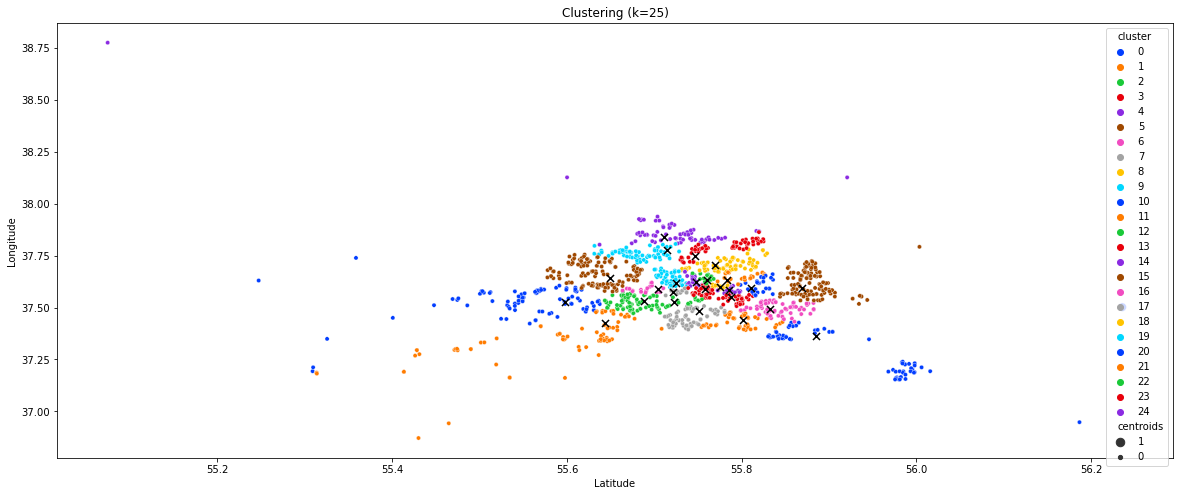

In [650]:
X = objects[["Latitude","Longitude"]]
map_shape = (5,5)
## scale data
scaler = preprocessing.StandardScaler()
X_preprocessed = scaler.fit_transform(X.values)
## clustering
model_som = MiniSom(x=map_shape[0], y=map_shape[1], input_len=X.shape[1])
model_som.train_batch(X_preprocessed, num_iteration=100, verbose=False)
## build output dataframe
objects_X = X.copy()
objects_X["cluster"] = np.ravel_multi_index(np.array([model_som.winner(x) for x in X_preprocessed]).T, dims=map_shape)

cluster_centers = np.array([vec for center in model_som.get_weights() for vec in center])
## find real centroids
cluster_centers = np.array([vec for center in model_som.get_weights() for vec in center])
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, X_preprocessed)
objects_X["centroids"] = 0
for i in closest: objects_X["centroids"].iloc[i] = 1

## add clustering info to the original dataset
objects[["cluster","centroids"]] = objects_X[["cluster","centroids"]]
## plot
k = objects["cluster"].nunique()
fig, ax = plt.subplots()

fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(20, 8)

sns.scatterplot(x="Latitude", y="Longitude", data=objects, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')
th_centroids = scaler.inverse_transform(cluster_centers)
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', marker="x")

In [651]:
address = 'Moscow, RU'

geolocator = Nominatim(user_agent="moscow_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


x, y = "Latitude", "Longitude"
color = "cluster"
popup = "District"
marker = "centroids"
data = objects.copy()

# create color column
lst_elements = sorted(list(objects[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))]
data["color"] = data[color].apply(lambda x: lst_colors[lst_elements.index(x)])

# create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))

# initialize the map with the starting location
map_ = folium.Map(location=[latitude, longitude], tiles="cartodbpositron", zoom_start=11)

# add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True).add_to(map_), axis=1)

# add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:12px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))
map_

In [652]:
for index in range(0,25):
    print(objects.loc[objects['cluster'] == index].shape)

(90, 10)
(83, 10)
(69, 10)
(57, 10)
(79, 10)
(119, 10)
(22, 10)
(14, 10)
(79, 10)
(69, 10)
(31, 10)
(29, 10)
(21, 10)
(36, 10)
(16, 10)
(114, 10)
(67, 10)
(67, 10)
(13, 10)
(55, 10)
(67, 10)
(49, 10)
(18, 10)
(36, 10)
(17, 10)


#### The most filled cluster is number 5. Let's look at its occupancy by category

In [662]:
cluster5 = objects.loc[objects['cluster'] == 5]
cluster5.to_csv(r'cluster5.csv')

#### Let's find out how many unique categories there are in the cluster

In [667]:
print('There are {} uniques categories.'.format(len(cluster5['Category'].unique())))
print(cluster5['Category'].unique())

There are 6 uniques categories.
['Pools' 'AdultHospital' 'AdultDentalClinic' 'ChildrenDentalClinic'
 'ChildrenHospital' 'School']


#### We can see that the cluster has all categories of objects

#### Let's find out what unique administrative areas Moscow has in the cluster

In [669]:
cluster5['AdmArea'].unique()

array(['Юго-Восточный административный округ',
       'Южный административный округ', 'Курьяновский парк',
       'исторический район Волхонка-ЗИЛ',
       'Юго-Западный административный округ'], dtype=object)

#### We can see that the cluster includes the following areas: 
* South-Eastern Administrative Area
* Southern Administrative Area 
* South-Western Administrative Area
* Kuryanovsky Park
* Volkhonka-ZIL historic district
#### Kuryanovsky Park, Volkhonka-ZIL historic district. These districts are not administrative districts of Moscow, but part of it:
* South-Eastern Administrative Area
* Southern Administrative Area 
* South-Western Administrative Area

#### Finally, let's visualize the resulting clusters

In [654]:
address = 'Moscow, RU'

geolocator = Nominatim(user_agent="moscow_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Moscow using latitude and longitude values
map_moscow = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name in zip(cluster5['Latitude'], cluster5['Longitude'], cluster5['ObjectName']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_moscow)  
    
map_moscow

## Result

#### As a result of the research, we found out that the optimal districts to live in Moscow for a family with children are:
* South-Eastern Administrative Area
* Southern Administrative Area 
* South-Western Administrative Area